In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import cv2 as cv
import time
# from picamera import PiCamera
# from picamera.array import PiRGBArray
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
# plt.switch_backend('nbAgg')
plt.style.use("seaborn")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (16/2, 9/2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}", r"\usepackage{url}"]

In [6]:
camera = PiCamera()
camera.resolution = (800, 600)
camera.framerate = 15
rawCapture = PiRGBArray(camera, size=(800, 600))
time.sleep(0.200)
for frame in camera.capture_continuous(rawCapture, format="bgr", use_video_port=True):
    image = frame.array
    cv.imshow("Image", image)
    key = cv.waitKey(1) & 0xFF
    rawCapture.truncate(0)
    
    if key == ord("q"):
        image = rawCapture.array
        cv.imwrite("act12_offset.png", image)
        break
cv.destroyAllWindows()

plt.imshow(cv.imread("act12_image.png"))
plt.show()

plt.imshow(cv.imread("act12_offset.png"))
plt.show()

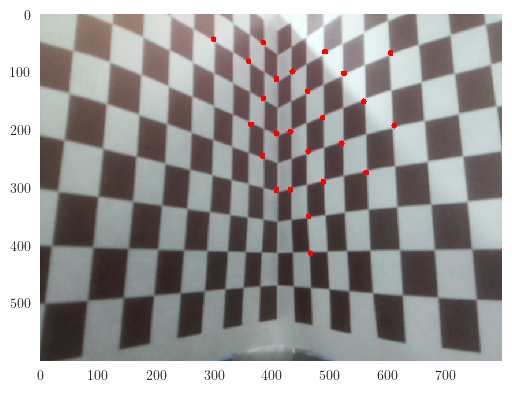

In [3]:
img = cv.imread('image.png')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

num_corners = 25
corners = cv.goodFeaturesToTrack(gray, num_corners, 0.01, 15)
corners = np.int0(corners)
pi = np.zeros((num_corners, 2))

for k, i in enumerate(corners):
    x, y = i.ravel()
    pi[k] = (x, y)
    cv.circle(img, (x, y), 5, 255, -1)
pi = pi[pi[:,1].argsort()]
plt.imshow(img)
plt.grid(0)
# plt.savefig('chosen_corners.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
pi

array([[300.,  43.],
       [386.,  49.],
       [493.,  65.],
       [607.,  67.],
       [361.,  81.],
       [437.,  99.],
       [526., 102.],
       [409., 112.],
       [463., 133.],
       [386., 145.],
       [560., 151.],
       [489., 179.],
       [365., 190.],
       [613., 192.],
       [433., 203.],
       [409., 206.],
       [522., 223.],
       [464., 237.],
       [385., 245.],
       [564., 274.],
       [490., 290.],
       [433., 304.],
       [409., 304.],
       [465., 349.],
       [468., 413.]])

In [5]:
u = 1.3 # cm
Pg = np.array([
    [ 4 , 0 , 8 ], # 1
    [ 1 , 0 , 9 ], # 2
    [ 0 , 3 , 8 ], # 3
    [ 0 , 6 , 7 ], # 4
    [ 2 , 0 , 8 ], # 5
    [ 0 , 1 , 8 ], # 6
    [ 0 , 4 , 7 ], # 7
    [ 0 , 0 , 8 ], # 8
    [ 0 , 2 , 7 ], # 9
    [ 1 , 0 , 7 ], # 10
    [ 0 , 5 , 6 ], # 11
    [ 0 , 3 , 6 ], # 12
    [ 2 , 0 , 6 ], # 13
    [ 0 , 6 , 5 ], # 14
    [ 0 , 1 , 6 ], # 15
    [ 0 , 0 , 6 ], # 16
    [ 0 , 4 , 5 ], # 17
    [ 0 , 2 , 5 ], # 18
    [ 1 , 0 , 5 ], # 19
    [ 0 , 5 , 4 ], # 20
    [ 0 , 3 , 4 ], # 21
    [ 0 , 1 , 4 ], # 22
    [ 0 , 0 , 4 ], # 23
    [ 0 , 2 , 4 ], # 24
    [ 0 , 2 , 2 ]  # 25
]) * u

Oi = np.array([408, 526])
Oo = np.zeros(3)

In [6]:
def calibrate(po, pi):
    Q = np.array([
        [ po[0] , po[1] , po[2] , 1 , 0 , 0 , 0 , 0 , -pi[0]*po[0] , -pi[0]*po[1] , -pi[0]*po[2] ],
        [ 0 , 0 , 0 , 0 , po[0] , po[1] , po[2] , 1 , -pi[1]*po[0] , -pi[1]*po[1] , -pi[1]*po[2] ]
    ])
    return Q

def predict(po, a):
    a11, a12, a13, a14, a21, a22, a23, a24, a31, a32, a33 = a
    xo, yo, zo = po
    xi = (a11*xo + a12*yo + a13*zo + a14)/(a31*xo + a32*yo + a33*zo + 1)
    yi = (a21*xo + a22*yo + a23*zo + a24)/(a31*xo + a32*yo + a33*zo + 1)
    return np.int0([xi, yi])

In [7]:
Q = np.zeros((2*num_corners, 11))
p = pi.ravel()
for k, (o, i) in enumerate(zip(Pg, pi)):
    Q[2*k : 2*k + 2] = calibrate(o, i)
a = la.inv(Q.T.dot(Q)).dot(Q.T).dot(p)
a

array([-2.65913296e+01,  1.57974150e-01, -1.65007482e+00,  4.14246552e+02,
       -1.38754044e+01, -1.55546586e+01, -3.78059633e+01,  5.02602610e+02,
       -2.16655601e-02, -4.04806146e-02, -3.03264178e-03])

In [8]:
pred = predict(Oo, a)
pred

array([414, 502], dtype=int64)

In [9]:
err = abs(la.norm(pred) - la.norm(Oi))/la.norm(Oi) * 100
err

2.2526594608345563

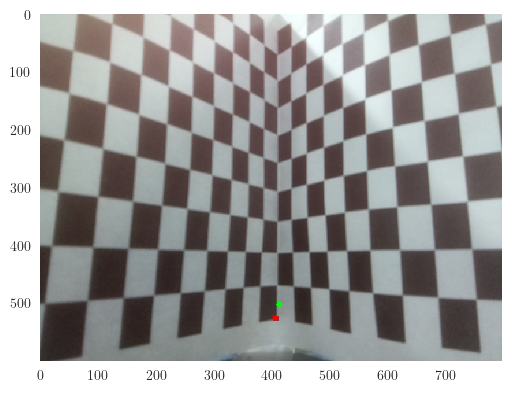

In [16]:
img = cv.imread('image.png')
cv.circle(img, tuple(pred), 5, (0, 255, 0), -1)
cv.circle(img, tuple(Oi), 5, (255, 0, 0), -1)
plt.imshow(img)
plt.grid(0)
# plt.savefig('origin_dev.png', dpi=300, bbox_inches='tight')
plt.show()